<a href="https://colab.research.google.com/github/nicklansley/decoding-tv-teddy/blob/main/decodingtvteddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script decodes the TV Teddy video-embedded audio track in a video fiulke sourced from official TV Teddy VHS recordings.



First we get all our imports performed here. If there any problems we'll know
before we get started. If running on a cloud Jupyter service such as Google Colab or Jetbrains Datalore then you have 'all batteries included'.

On a local machine you will likely need to run:
1. pip install opencv-python
2. pip install librosa
3. pip install matplotlib

If running on Windows 10, you may need to enable LongPaths if installing librosa causes errors. In PowerShell:
New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name "LongPathsEnabled" -Value 1 -PropertyType DWORD -Force

If running on a local machine you will also need to comment out the drive.mount() command in the first code block.

In [1]:
import cv2
import array
import wave
import librosa
import IPython.display as idp
from google.colab import drive
drive.mount('/content/gdrive')

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

media_file_path = '/content/gdrive/MyDrive/Colab Notebooks/decodingtvteddy_media/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Let's get started then - read the video file and extract every 100th freame

In [2]:
print('TV Teddy Frame Extractor - CV2 version = ', cv2.__version__)
vidcap = cv2.VideoCapture(media_file_path + 'TVTeddy 640x480 29.97fps 2Mbps.mp4')
success, image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    count += 1
    if count % 100 == 0:
        print('count of frames so far =', count)
        cv2.imwrite(media_file_path + "frame%d.jpg" % count, image)  # save frame as JPEG file

print('total count of frames =', count)

TV Teddy Frame Extractor - CV2 version =  4.1.2
count of frames so far = 100
count of frames so far = 200
count of frames so far = 300
count of frames so far = 400
total count of frames = 411


In the media folder, four frame images have been extracted. This shows that:
1. The video file is OK and we will certainmly be able to get to each frame.
2. The video-emebedded audio is clearly visible!
Here is frame 300:

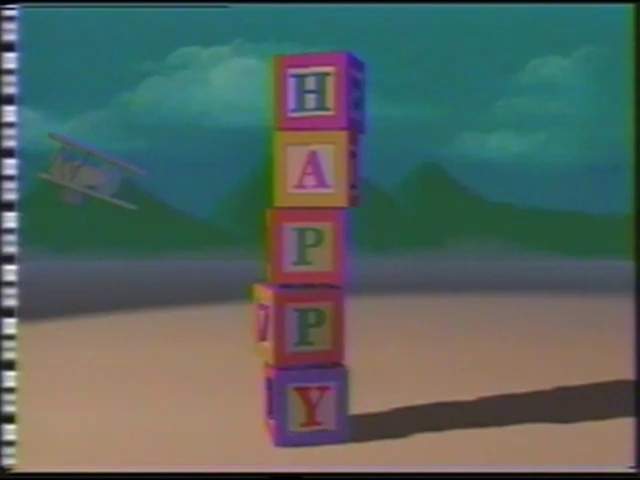

In [3]:
idp.Image(media_file_path + "frame300.jpg")

Inspecting this image, the video-embedded-audio extens horizontally fropm pixel 1 to pixel 8 in this 640 x 480 image.
Vertically, that 'audio' extends from pixel 4 to 432.

So my plan is to:

1. Read each frame, and do this:

    1a. Set a loop running from value 0 to value 639 and, at each position (5, 2) through to (5, 432) do these steps:

	    1aa. Read the RGB value of the pixels and add those three values together together, subtracting 127 from each so that the waveform centres on value 0 and not on value 127. The values will be sampled between 0 and 255 so subtracting 127 will make them become sampled between 128 and -127. ‘Silence’ (denoted by grey rather than black or white) will then be recorded at 0 and not at 127. Summing the three R, G, and B samples will help with any subtlety that can still be derived from the change in greyness from sample to sample despite digitisation. I’ll save this value as a 16-bit signed integer.

	    1ab. Append the value to the end of an array which later is saved to the WAV file.

2. 'Normalise' the array of audio samples; that is, ‘amplify’ the sample values and re-centre them around the ‘0’ centre line.

3. Save the array of samples in a WAV file requested to playback at 30 fps x (432 - 2) frame-lines per second = 12900 KHz sample rate with 16bit sample size.

In [4]:
# A flag used to find out if the next video frame was read successfully
success = True

# Audio samples are counted into this variable:
currentSampleCount = 0

# This is the output WAV file's sample rate that will be written into its header information
wavSampleRate = 20483
# Each WAV file sample is 2 bytes (16-bit)
wavSampleSize = 2

# The Wav file will have a single mono audio channel
wavChannels = 1

# An array that will store all samples in a 16-bit signed integer format
sampleArray = array.array('h')

# The top and bottom video lines in the video frame where will measure the greyscale to get samples
# increase audioLineModulationStartLine and decrease audioLineModulationEndLine until the loud 60Hz buzz disappears
# from the finished audio
audioLineModulationStartLine = 2
audioLineModulationEndLine = 432

# The horizontal position in the video frame where we will take the sample - ideally set to be in the centre
# of the greyscale audio line
audioLineCentrePixelToRead = 5

print('TV Teddy Audio Extractor - CV2 version = ', cv2.__version__)
frameCount = 0

# Open the video file
vidcap = cv2.VideoCapture(media_file_path + 'TVTeddy 640x480 29.97fps 2Mbps.mp4')

if vidcap.isOpened():
    # Get some info on the file
    width = vidcap.get(cv2.CAP_PROP_FRAME_WIDTH)  # float
    height = vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('Incoming Video: Width=', width, ', height=', height, ', fps=', fps, ', framecount=', frameCount)

    # Process the file frame by frame
    for currentFrame in range(0, frameCount):
        success, image = vidcap.read()

        if success:
            # For the current frame, read the grey line and extract a sample from each pixel
            for scanLine in range(audioLineModulationStartLine, audioLineModulationEndLine + 1):
                sampleValue = 0
                for rgb in range(0, 3):
                    sampleValue += int(image[scanLine, audioLineCentrePixelToRead, rgb])
                sampleArray.append(sampleValue)

        else:
            print('Failed to read frame', currentFrame)

        if currentFrame % 100 == 0:
            print('count of frames so far =', currentFrame, ' - ', int(currentFrame * 100 / frameCount), "%")

    # Close the incoming video file
    vidcap.release()

print('Total count of frames =', frameCount)
print('Total count of samples =', currentSampleCount)

print('Analysing extracted audio...')
# Find the sum of sample sizes and the minimum & maximum sample size
sumSampleSize = 0
maxSampleValue = 0

for sampleIndex in range(0, len(sampleArray) - 1):
    sumSampleSize += sampleArray[sampleIndex]
    if maxSampleValue < sampleArray[sampleIndex]:
        maxSampleValue = sampleArray[sampleIndex]

# Calculate mean average sample size
meanSampleSize = int(sumSampleSize / len(sampleArray))

# Now alter the sample values to become rebalanced around zero based
# on the mean sample size, and amplified by multiplying the samples
# based on the amplifyValue - a process called 'normalisation'
print('Normalising....')
maxSampleValue = maxSampleValue - meanSampleSize
amplifyValue = 16000 / maxSampleValue  # reduce constant value 16000 if Warnings below keep happening
for sampleIndex in range(0, len(sampleArray)):
    # Safety catch shown multiplication make signed integer too big or too small for the array
    try:
        sampleArray[sampleIndex] = int((sampleArray[sampleIndex] - meanSampleSize) * amplifyValue)
    except OverflowError:
        # sampleArray[sampleIndex] is kept at the same value
        print("Warning: Normalised sample was too large or too small for signed 16-bit array")
        continue

# Write the output WAV file
print('Writing WAV file...')
f = wave.open(media_file_path + 'output.wav', 'w')
f.setparams((wavChannels, wavSampleSize, wavSampleRate, len(sampleArray), "NONE", "Uncompressed"))
f.writeframes(sampleArray.tobytes())  # Important to convert to string or only half the audio will be written out
f.close()

print('Completed!')


TV Teddy Audio Extractor - CV2 version =  4.1.2
Incoming Video: Width= 640.0 , height= 480.0 , fps= 29.97002997002997 , framecount= 411
count of frames so far = 0  -  0 %
count of frames so far = 100  -  24 %
count of frames so far = 200  -  48 %
count of frames so far = 300  -  72 %
count of frames so far = 400  -  97 %
Total count of frames = 411
Total count of samples = 0
Analysing extracted audio...
Normalising....
Writing WAV file...
Completed!


Let's take a look at the output:

The number of samples is (190693,) and the sample rate is 22050


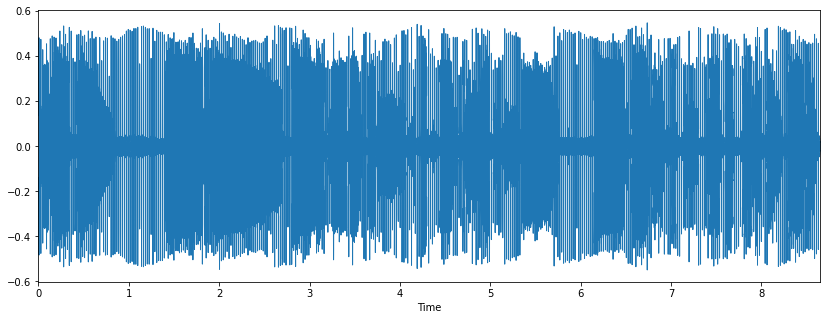

In [5]:
x, sr = librosa.load(media_file_path + 'output.wav')
print("The number of samples is", x.shape, "and the sample rate is", sr)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)



Let's have a listen:

In [6]:
idp.Audio(media_file_path + "/output.wav")